![](cover.png)

# 圖像翻譯 - PIX2PIX

In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#from urllib.request import urlretrieve
#url = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/night2day.tar.gz'
#dest = '/gdrive/My Drive/keras/pix2pix/night2day.tar.gz'
#urlretrieve(url, dest)

In [0]:
import tarfile
dest = '/gdrive/My Drive/keras/pix2pix/maps.tar.gz'
f = tarfile.open(dest)
f.extractall('./maps/')

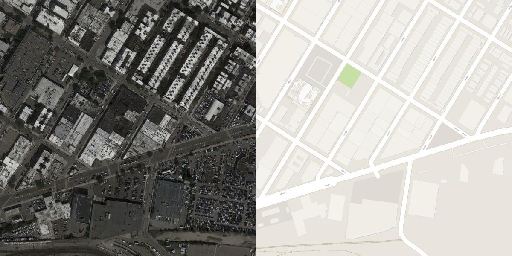

In [7]:
import glob
from PIL import Image
imglist = glob.glob('./maps/maps/train/*')
oriimage = Image.open(imglist[0])
oriimage.resize((512, 256))

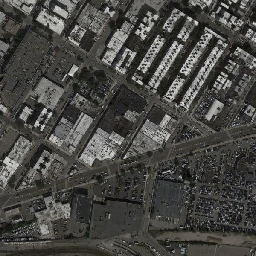

In [8]:
left = oriimage.crop((0, 0, int(oriimage.size[0] / 2), oriimage.size[1]))
left.resize((256, 256))

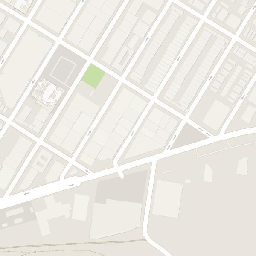

In [9]:
right = oriimage.crop((int(oriimage.size[0] / 2), 0, oriimage.size[0], oriimage.size[1]))
right.resize((256, 256))

In [0]:
img_shape = (256, 256, 3)

In [205]:
from keras.optimizers import Adam

def d_layer(layer_input, filters, f_size=4):
    """Discriminator layer"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization(momentum=0.8)(d)
    return d

  
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

combined_imgs = Concatenate(axis=-1)([img_A, img_B])

d1 = d_layer(combined_imgs, 64)
d2 = d_layer(d1, 128)
d3 = d_layer(d2, 256)
d4 = d_layer(d3, 512)
validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
discriminator = Model([img_A, img_B], validity)

optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss='mse', optimizer=optimizer)
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_50 (Concatenate)    (None, 256, 256, 6)  0           input_42[0][0]                   
                                                                 input_43[0][0]                   
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 128, 128, 64) 6208        concatenate_50[0][0]             
__________

In [206]:
def conv2d(layer_input, filters, f_size=4):
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    d = BatchNormalization(momentum=0.8)(d)
    return d

def deconv2d(layer_input, skip_input, filters, f_size=4):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
    u = LeakyReLU(alpha=0.2)(u)
    u = BatchNormalization(momentum=0.8)(u)
    u = Concatenate()([u, skip_input])
    return u

# Image input
d0 = Input(shape=img_shape)

# Downsampling
d1 = conv2d(d0, 64)
d2 = conv2d(d1, 128)
d3 = conv2d(d2, 256)
d4 = conv2d(d3, 512)
d5 = conv2d(d4, 512)
d6 = conv2d(d5, 512)
d7 = conv2d(d6, 512)

# Upsampling
u1 = deconv2d(d7, d6, 512)
u2 = deconv2d(u1, d5, 512)
u3 = deconv2d(u2, d4, 512)
u4 = deconv2d(u3, d3, 256)
u5 = deconv2d(u4, d2, 128)
u6 = deconv2d(u5, d1, 64)

u7 = UpSampling2D(size=2)(u6)
output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

generator = Model(d0, output_img)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 128, 128, 64) 3136        input_44[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_124 (LeakyReLU)     (None, 128, 128, 64) 0           conv2d_139[0][0]                 
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 128, 128, 64) 256         leaky_re_lu_124[0][0]            
__________________________________________________________________________________________________
conv2d_140

from google.colab import drive
drive.mount('/gdrive')
from keras.models import load_model
generator = load_model('/gdrive/My Drive/keras/pix2pix/pix2pix_gen.h5')
discriminator = load_model('/gdrive/My Drive/keras/pix2pix/pix2pix_dis.h5')
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import BatchNormalization, UpSampling2D, Conv2D

In [207]:
# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                 loss_weights=[1, 25],
                 optimizer=optimizer)
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_26 (Model)                (None, 256, 256, 3)  41843587    input_46[0][0]                   
__________________________________________________________________________________________________
model_25 (Model)                (None, 16, 16, 1)    2771649     model_26[1][0]                   
                                                                 input_46[0][0]                   
Total params: 44,615,236
Trainable params: 41,834,627
Non-trainable params: 2,780,609
__________________________________________________________________________________________________


In [209]:
patch = int(256 / 2**4)
disc_patch = (patch, patch, 1)
disc_patch

(16, 16, 1)

In [0]:
batch_size = 4
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

In [0]:
train_count =  1000
for train in range(0, train_count):
   
    rid = np.random.randint(0, len(imglist), batch_size)

    imgs_A = []
    imgs_B = []
    for i in rid:
        oriimage = Image.open(imglist[i])
        left = oriimage.crop((0, 0, int(oriimage.size[0] / 2), oriimage.size[1]))
        left = left.resize((256, 256))
        left = np.array(left)

        right = oriimage.crop((int(oriimage.size[0] / 2), 0, oriimage.size[0], oriimage.size[1]))
        right = right.resize((256, 256))
        right = np.array(right)


        imgs_A.append((left - 127.5)/127.5)
        imgs_B.append((right - 127.5)/127.5)


    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)
    fake_A = generator.predict(imgs_B)

    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    
    if (train + 1) % 100 == 0:
      dash = "-" * 15
      print(dash, "Train", train + 1, dash)
      print("Discriminator loss:", d_loss)
      print("Generator loss:", g_loss)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


--------------- Train 100 ---------------
Discriminator loss: 0.02337343990802765
Generator loss: [5.5632443, 0.8456586, 0.18870342]
--------------- Train 200 ---------------
Discriminator loss: 0.009673063643276691
Generator loss: [5.6186357, 0.99061793, 0.18512072]
--------------- Train 300 ---------------
Discriminator loss: 0.013592427596449852
Generator loss: [5.7744145, 0.9892764, 0.19140553]


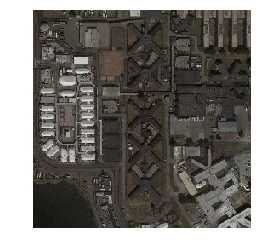

In [174]:
imga = 0.5 * imgs_A + 0.5
plt.axis('off')
plt.imshow(imga[2])

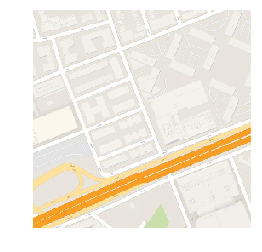

In [216]:
imgb = 0.5 * imgs_B + 0.5
plt.axis('off')
plt.imshow(imgb[2])

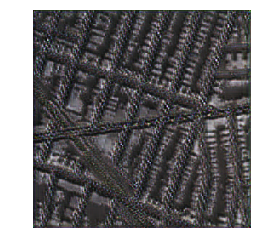

In [218]:
fakenew = 0.5 * fake_A + 0.5
plt.axis('off')
plt.imshow(fakenew[1])

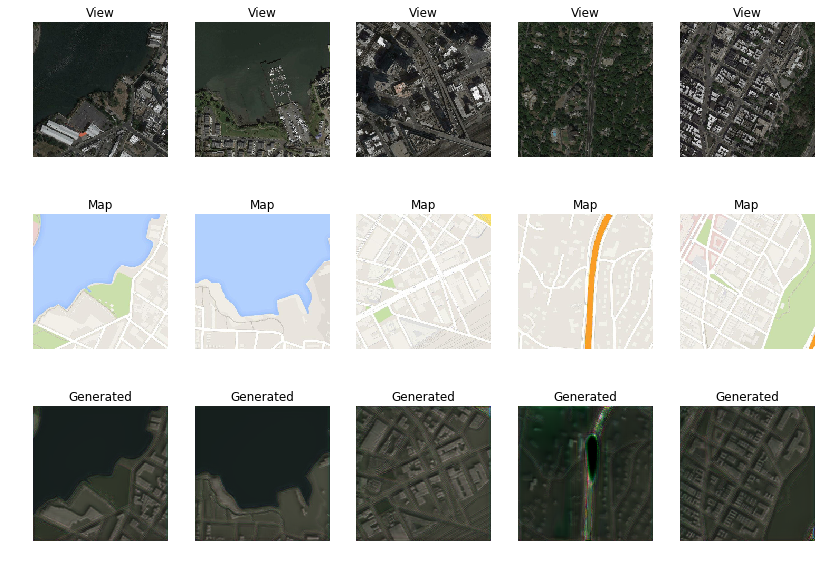

In [200]:
import random
from imageio import imread

examples = 5
plt.figure(figsize=(14, 10))

for i in range(examples):
    idx = random.randint(0, len(imglist) - 1)

    testimage = Image.open(imglist[idx])
    testleft = testimage.crop((0, 0, int(testimage.size[0] / 2), testimage.size[1]))
    testleft = testleft.resize((256, 256))
    testleft = np.array(testleft)
    testright = testimage.crop((int(testimage.size[0] / 2), 0, testimage.size[0], testimage.size[1]))
    testright = testright.resize((256, 256))
    testright = np.array(testright)

    count = i + 1
    plt.subplot(3, examples, count)
    plt.title('View')
    plt.axis('off')
    plt.imshow(testleft)
    plt.subplot(3, examples, count + examples)
    plt.title('Map')
    plt.axis('off')
    plt.imshow(testright)

    testright = (testright - 127.5)/127.5

    trans = generator.predict(np.array([testright]))
    trans = 0.5 * trans + 0.5
    plt.subplot(3, examples, count + 2 * examples)
    plt.title('Generated')
    plt.axis('off')
    plt.imshow(trans[0])

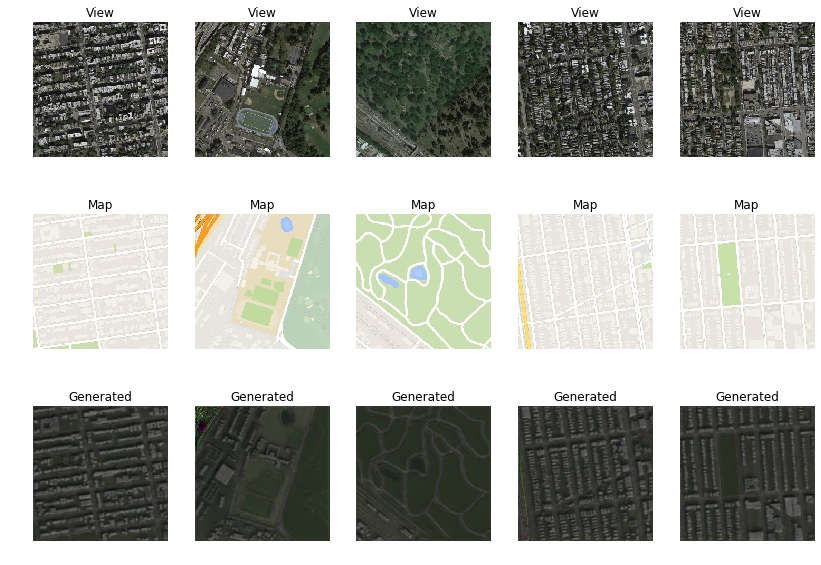

In [167]:
import random
from imageio import imread

val_imglist = glob.glob('./maps/maps/val/*')

examples = 5
plt.figure(figsize=(14, 10))

for i in range(examples):
    idx = random.randint(0, len(val_imglist) - 1)

    testimage = Image.open(val_imglist[idx])
    testleft = testimage.crop((0, 0, int(testimage.size[0] / 2), testimage.size[1]))
    testleft = testleft.resize((256, 256))
    testleft = np.array(testleft)
    testright = testimage.crop((int(testimage.size[0] / 2), 0, testimage.size[0], testimage.size[1]))
    testright = testright.resize((256, 256))
    testright = np.array(testright)

    count = i + 1
    plt.subplot(3, examples, count)
    plt.title('View')
    plt.axis('off')
    plt.imshow(testleft)
    plt.subplot(3, examples, count + examples)
    plt.title('Map')
    plt.axis('off')
    plt.imshow(testright)

    testright = (testright - 127.5)/127.5

    trans = generator.predict(np.array([testright]))
    trans = 0.5 * trans + 0.5
    plt.subplot(3, examples, count + 2 * examples)
    plt.title('Generated')
    plt.axis('off')
    plt.imshow(trans[0])

In [0]:
from google.colab import drive
drive.mount('/gdrive')
generator.save('/gdrive/My Drive/keras/pix2pix/pix2pix_map_gen.h5')
discriminator.save('/gdrive/My Drive/keras/pix2pix/pix2pix_map_dis.h5')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
